In [2]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.3 MB/s 


In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install tensorflow.keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [49]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [8]:
#جداسازی داده ها
train_subjects, test_subjects = model_selection.train_test_split( node_subjects, train_size=140, test_size=None, stratify=node_subjects)

val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)

In [9]:
#تعداد کلاس ها
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [12]:
#تبدیل به بردار (one-hot)
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)
print (test_targets[6])

[0 0 0 1 0 0 0]


In [13]:
#این کلاس در واقع اطلاعات گراف را برای ورودی مدل میتواند آماده کند
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [14]:
#داده های ورودی را اماده میکنیم
train_gen = generator.flow(train_subjects.index, train_targets)

In [16]:
#.مشخصات مدل را می دهیم.مدل شامل دولایه که هرکدام 16 نود دارند و فعالسازشان رلیو است می باشد.نصف داده هارا هم به عنوان دراپ اوت در نظر میگیریم ومدل را ایجاد میکنیم
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [17]:
#خروجی یک بردار 16 بعدی را برای هر گره در هنگام اموزش یا پیش بینی نگه میدارد.وپیش بینی واقعی هرگره از این بردار محاسبه میشود.یک لایه اضافی با یک نود هم دارد که از سافت مکس استفاده میکند برای محاسبه احتمال هرکلاس
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [19]:
#prediction برابر است با بیشترین مقدار سافت مکس
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

 **training and evaluation**

In [20]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
#میخواهیم عملکرد را در داده های ارزیابی هم حفظ کنیم ،یعنی یک مولد داده های دیگر هم باید ایجاد کنیم برای داده های ارزیابی
val_gen = generator.flow(val_subjects.index, val_targets)

In [32]:
#یک مقدار توقف برای ایپوک هاست که اگر دقت بهتر نشد دیگه ادامه ندهد
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)

In [33]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 0.0224 - acc: 1.0000 - val_loss: 0.7915 - val_acc: 0.8280 - 185ms/epoch - 185ms/step
Epoch 2/200
1/1 - 0s - loss: 0.0377 - acc: 0.9857 - val_loss: 0.7894 - val_acc: 0.8300 - 146ms/epoch - 146ms/step
Epoch 3/200
1/1 - 0s - loss: 0.0258 - acc: 0.9929 - val_loss: 0.7890 - val_acc: 0.8280 - 144ms/epoch - 144ms/step
Epoch 4/200
1/1 - 0s - loss: 0.0298 - acc: 0.9929 - val_loss: 0.7891 - val_acc: 0.8260 - 156ms/epoch - 156ms/step
Epoch 5/200
1/1 - 0s - loss: 0.0086 - acc: 1.0000 - val_loss: 0.7904 - val_acc: 0.8280 - 150ms/epoch - 150ms/step
Epoch 6/200
1/1 - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.7928 - val_acc: 0.8280 - 143ms/epoch - 143ms/step
Epoch 7/200
1/1 - 0s - loss: 0.0203 - acc: 1.0000 - val_loss: 0.7919 - val_acc: 0.8300 - 156ms/epoch - 156ms/step
Epoch 8/200
1/1 - 0s - loss: 0.0214 - acc: 1.0000 - val_loss: 0.7923 - val_acc: 0.8300 - 140ms/epoch - 140ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0134 - acc: 1.0000 - val_loss: 0.7943 - val_acc: 0.8340 -

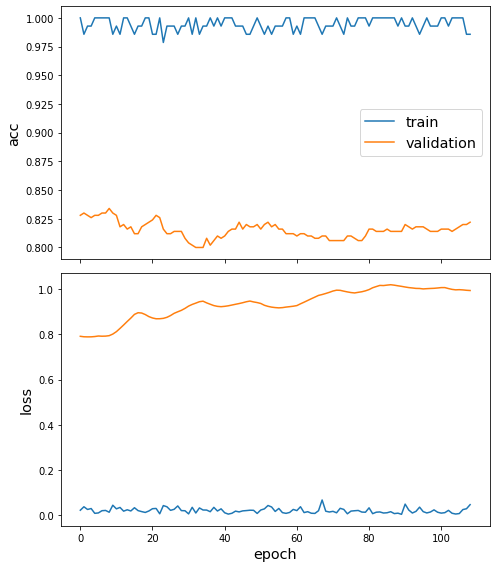

In [34]:
sg.utils.plot_history(history)

In [36]:
#مولد تولید داده های تست
test_gen = generator.flow(test_subjects.index, test_targets)

In [37]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 67ms/step - loss: 0.8701 - acc: 0.8104

Test Set Metrics:
	loss: 0.8701
	acc: 0.8104


In [38]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [39]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [40]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Probabilistic_Methods,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


**Creating the GraphSAGE model**

In [65]:
batch_size = 50
num_samples = [10, 5]
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

**training graphsage**

In [66]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
test_gen = generator.flow(test_subjects.index, test_targets)


In [68]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
3/3 - 4s - loss: 1.9097 - acc: 0.2429 - val_loss: 1.7789 - val_acc: 0.3245 - 4s/epoch - 1s/step
Epoch 2/20
3/3 - 3s - loss: 1.7074 - acc: 0.4143 - val_loss: 1.6961 - val_acc: 0.3399 - 3s/epoch - 935ms/step
Epoch 3/20
3/3 - 2s - loss: 1.5979 - acc: 0.4286 - val_loss: 1.6080 - val_acc: 0.4541 - 2s/epoch - 630ms/step
Epoch 4/20
3/3 - 2s - loss: 1.4901 - acc: 0.6357 - val_loss: 1.5204 - val_acc: 0.5740 - 2s/epoch - 631ms/step
Epoch 5/20
3/3 - 3s - loss: 1.3711 - acc: 0.8286 - val_loss: 1.4399 - val_acc: 0.6605 - 3s/epoch - 940ms/step
Epoch 6/20
3/3 - 3s - loss: 1.2951 - acc: 0.8429 - val_loss: 1.3677 - val_acc: 0.7224 - 3s/epoch - 936ms/step
Epoch 7/20
3/3 - 3s - loss: 1.1922 - acc: 0.9571 - val_loss: 1.3039 - val_acc: 0.7471 - 3s/epoch - 936ms/step
Epoch 8/20
3/3 - 2s - loss: 1.1149 - acc: 0.9500 - val_loss: 1.2549 - val_acc: 0.7548 - 2s/epoch - 642ms/step
Epoch 9/20
3/3 - 2s - loss: 1.0329 - acc: 0.9714 - val_loss: 1.2041 - val_acc: 0.7563 - 2s/epoch - 642ms/step
Epoch 10/20
3

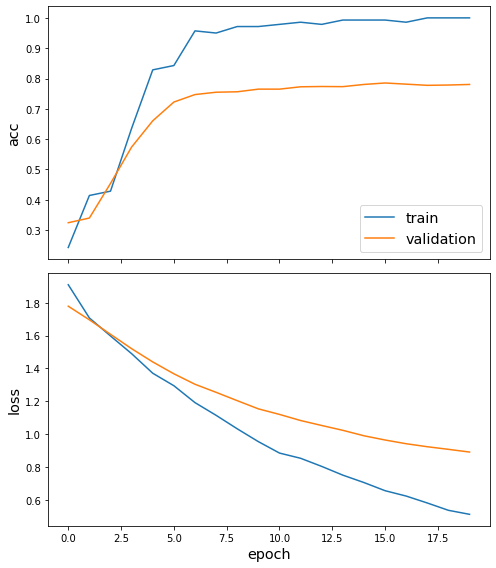

In [69]:
sg.utils.plot_history(history)


In [70]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

42/42 [==============================] - 2s 40ms/step - loss: 0.8913 - acc: 0.7814

Test Set Metrics:
	loss: 0.8913
	acc: 0.7814


In [71]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions1 = target_encoding.inverse_transform(all_predictions)


df = pd.DataFrame({"Predicted": node_predictions1, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Probabilistic_Methods,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


**Creating the GAT model**

In [51]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["relu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()


In [52]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [54]:
val_gen = generator.flow(val_subjects.index, val_targets)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [55]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 7s - loss: 1.9661 - acc: 0.1286 - val_loss: 1.8896 - val_acc: 0.3820 - 7s/epoch - 7s/step
Epoch 2/50
1/1 - 0s - loss: 1.8539 - acc: 0.3571 - val_loss: 1.8332 - val_acc: 0.4100 - 391ms/epoch - 391ms/step
Epoch 3/50
1/1 - 0s - loss: 1.8147 - acc: 0.3714 - val_loss: 1.7759 - val_acc: 0.3980 - 326ms/epoch - 326ms/step
Epoch 4/50
1/1 - 0s - loss: 1.7489 - acc: 0.4357 - val_loss: 1.7180 - val_acc: 0.4060 - 347ms/epoch - 347ms/step
Epoch 5/50
1/1 - 0s - loss: 1.6767 - acc: 0.4071 - val_loss: 1.6588 - val_acc: 0.4120 - 384ms/epoch - 384ms/step
Epoch 6/50
1/1 - 0s - loss: 1.6311 - acc: 0.4071 - val_loss: 1.5998 - val_acc: 0.4140 - 362ms/epoch - 362ms/step
Epoch 7/50
1/1 - 0s - loss: 1.5340 - acc: 0.4643 - val_loss: 1.5405 - val_acc: 0.4360 - 351ms/epoch - 351ms/step
Epoch 8/50
1/1 - 0s - loss: 1.4517 - acc: 0.5000 - val_loss: 1.4813 - val_acc: 0.4580 - 366ms/epoch - 366ms/step
Epoch 9/50
1/1 - 0s - loss: 1.3802 - acc: 0.5643 - val_loss: 1.4239 - val_acc: 0.4900 - 361ms/epoch - 

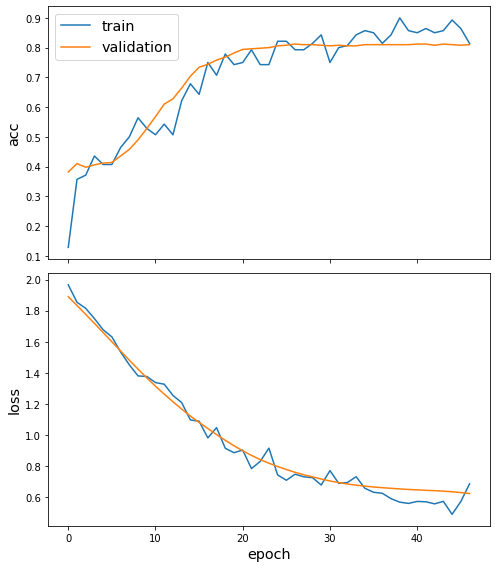

In [56]:
sg.utils.plot_history(history)


In [57]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 95ms/step - loss: 0.6400 - acc: 0.8240

Test Set Metrics:
	loss: 0.6400
	acc: 0.8240


In [58]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Probabilistic_Methods,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory
